# 透過資料預測產品是否能成功

_**使用 XGBoost模型來預測銷售量是否超過"熱門"的設定範圍**_

---

---

## 內容說明

1. [背景](#背景)
1. [設定](#設定)
1. [資料](#資料)
1. [訓練模型](#訓練模型)
1. [部署模型](#部署模型)
1. [評估模型](#評估模型)
1. [額外評估](#額外評估)


## 背景

　　我們一般會透過使用者、評論家、社群媒體等等的評論來判斷一個產品最後是否會成功。特別是在遊戲產業，評論跟評分對於遊戲的成功有著巨大的影響。
然而，不是所有被評為不好的遊戲最後會失敗，也不是備受好評的遊戲會熱門(這邊熱門指的是銷售量)。透過機器學習來預測遊戲是否熱門，可以找到除了評論之外的相關資料屬性。

　　這個Case，我們會使用一個電玩遊戲銷售量及評分的資料集。這個[資料集](http://www.metacritic.com/browse/games/release-date/available)包含的屬性有使用者評論(user reviews)、評論家評論(critic reviews)、銷售量(sales)、ESRB評分(ESRB ratings)等等。使用者及評論家評論被統計成0到10分或0到100分。雖然這樣很方便，但是在相對小的資料集會造成重要的影響。
  
　　處理在小資料集在機器學習中是常見的問題，小資料集加上資料類別屬性分佈不均的問題會導致分析難度增加。在這種狀況，使用整體學習器(ensemble learner)是一個適合的選擇，這個notebook會使用XGBoost整體學習器(ensemble learner)來預測遊戲是否熱門。



## 設定

Let's start by specifying:

開始設定細節

- 設定你想要放資料跟訓練模型的S3 bucket跟位置(prefix)，記得要跟所使用的Notebook Instance同個區域(Region)

- 設定IAM role arn給training跟host的instance存取資料，一般可以直接使用`get_execution_role()`來取得之前設定的權限，如果需要額外設定也可以修改這個參數。

In [1]:
bucket = 'your-s3-bucket-name'
prefix = 'sagemaker/videogames_xgboost'
 
import sagemaker

role = sagemaker.get_execution_role()

接下來載入所需要的Python套件

In [2]:
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt   
from IPython.display import Image                 
from IPython.display import display               
from sklearn.datasets import dump_svmlight_file   
from time import gmtime, strftime                 
import sys                                        
import math                                       
import json
import boto3

---
## 資料

將公開的資料集下載到你的notebook的instance內

In [3]:
raw_data_filename = 'Video_Games_Sales_as_at_22_Dec_2016.csv'
data_bucket = 'sagemaker-workshop-pdx'

s3 = boto3.resource('s3')
s3.Bucket(data_bucket).download_file(raw_data_filename, 'raw_data.csv')

data = pd.read_csv('./raw_data.csv')
pd.set_option('display.max_rows', 20) 
data

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26,NaN,NaN,NaN,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.44,6.94,4.70,2.24,28.32,87.0,80.0,8.4,594.0,Nintendo,E
9,Duck Hunt,NES,1984.0,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31,NaN,NaN,NaN,NaN,NaN,NaN



在分析之前，需要先定義要預測的目標。遊戲開發預算可能需要數千萬美金，所以對開發商來講，回收成本跟創造利潤是很重要的考量。
因此，先定義"熱門遊戲"為在全球超過1百萬銷售量的遊戲(Global_Sales這邊的單位為百萬)，所以大於1單位就是熱門。

In [4]:
data['y'] = (data['Global_Sales'] > 1)

當預測的目標被定義後，來觀察一下熱門跟非熱門的資料分佈狀況

In [5]:
data['Rating'].value_counts()

E       3991
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: Rating, dtype: int64

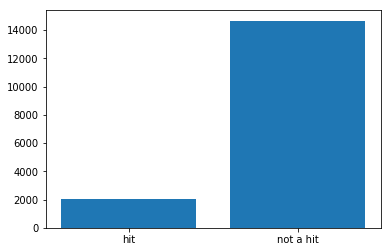

In [6]:
plt.bar(['not a hit', 'hit'], data['y'].value_counts())
plt.show()

不出所料，在我們設定的指標下，只有一小部份的遊戲被認為是熱門。
接下來我們選擇我們想要的資料屬性來預測遊戲是否熱門。
我們可以透過資料視覺化來比較評分(review scores)跟全球銷售量(global sales)，確認我們假設評分對銷售量有影響。
這邊取對數(log)當單位來讓呈現更清楚。

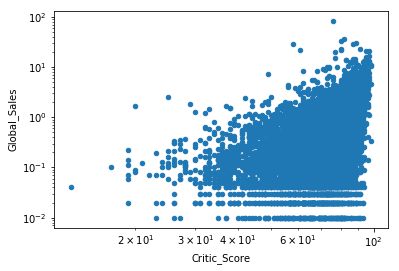

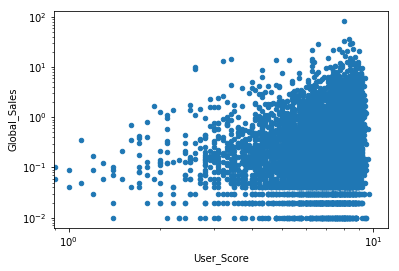

In [7]:
viz = data.filter(['User_Score','Critic_Score', 'Global_Sales', 'Genre', 'Rating'], axis=1)
viz['Genre'] = viz['Genre'].astype('category')
viz['User_Score'] = pd.Series(viz['User_Score'].apply(pd.to_numeric, errors='coerce'))
viz['User_Score'] = viz['User_Score'].mask(np.isnan(viz["User_Score"]), viz['Critic_Score'] / 10.0)
viz.plot(kind='scatter', logx=True, logy=True, x='Critic_Score', y='Global_Sales')
viz.plot(kind='scatter', logx=True, logy=True, x='User_Score', y='Global_Sales')
plt.show()

分析遊戲類別(Genre)與銷售量跟評分的關係

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


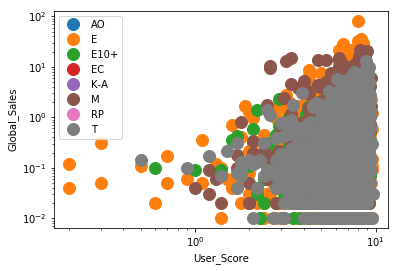

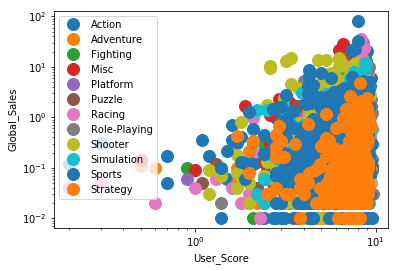

In [8]:
groups1 = viz.groupby('Rating')
groups2 = viz.groupby('Genre')

# Plot

fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax.set_yscale('log') # set log scale
ax.set_xscale('log')
for name, groups1 in groups1:
    ax.plot(groups1.User_Score, groups1.Global_Sales, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.ylabel('Global_Sales')
plt.xlabel('User_Score')

fig1, ax1 = plt.subplots()
ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax1.set_yscale('log') # set log scale
ax1.set_xscale('log')
for name, groups2 in groups2:
    ax1.plot(groups2.User_Score, groups2.Global_Sales, marker='o', linestyle='', ms=12, label=name)
ax1.legend()

plt.ylabel('Global_Sales')
plt.xlabel('User_Score')
plt.show()

我們關於評分於銷售量的假設看起來是合理的。我們也注意到其他屬性的一些關係。
例如ESRB的評級有蠻大的影響力，因為通常被分為"E"級的遊戲，受眾會多於被分為"M"級這類限制年齡的遊戲，
但是還需要考量到遊戲類型(genre)這個屬性，例如說射擊類或動作類，所以被分為"M"級的遊戲也可能是熱門遊戲。
因此希望透過模型來協助分析這些關係。

接下來，可以把覺得與銷售量相關的欄位過濾出來，去除掉像是遊戲名稱這種對銷售量沒有關係的欄位資料

In [9]:
data = data.drop(['Name', 'Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Count', 'User_Count', 'Developer'], axis=1)

將需要的欄位過濾出來後，就可以來計算一下有多少缺失值

In [10]:
data.isnull().sum()

Platform           0
Genre              2
Publisher         54
Critic_Score    8582
User_Score      6704
Rating          6769
y                  0
dtype: int64

將有缺失值的資料過濾掉

In [11]:
data = data.dropna()

User_Score 處理掉非數值的資料轉換成數值資料
如果沒辦法轉換用Critic_Score替代

In [12]:
data['User_Score'] = data['User_Score'].apply(pd.to_numeric, errors='coerce')
data['User_Score'] = data['User_Score'].mask(np.isnan(data["User_Score"]), data['Critic_Score'] / 10.0)

使用one-hot encoding轉換類別資料成dummy variable

In [13]:
data['y'] = data['y'].apply(lambda y: 'yes' if y == True else 'no')
model_data = pd.get_dummies(data)

避免模型過度擬合(overfitting)，我們隨機將資料分成3個份，70%用於訓練。20%用來評估模型的準確度，最後10%用來測試最後的結果。

In [15]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])   

XGBoost所使用的資料格式為libSVM，轉換資料並放到S3作為SageMaker訓練使用

In [ ]:
dump_svmlight_file(X=train_data.drop(['y_no', 'y_yes'], axis=1), y=train_data['y_yes'], f='train.libsvm')
dump_svmlight_file(X=validation_data.drop(['y_no', 'y_yes'], axis=1), y=validation_data['y_yes'], f='validation.libsvm')
dump_svmlight_file(X=test_data.drop(['y_no', 'y_yes'], axis=1), y=test_data['y_yes'], f='test.libsvm')

boto3.Session().resource('s3').Bucket(bucket).Object(prefix + '/train/train.libsvm').upload_file('train.libsvm')
boto3.Session().resource('s3').Bucket(bucket).Object(prefix + '/validation/validation.libsvm').upload_file('validation.libsvm')

---
## 訓練模型

資料已經準備完畢，接下來是使用XGBoost model來訓練。XGBoost有很多超參數可以調整來優化模型。以下列出比較會用到的參數。

- `max_depth`: 樹的深度，太小會不足以反應資料的特性，太多會導致過度擬合

- `eta`: 學習的步驟大小，用來避免過度擬合
- `eval_metric`: 用來評估模型的指標
- `scale_pos_weight`: 如果遇到不平衡的分佈可以用這個參數來作調整

直接開始訓練吧! 訓練過程約6-10分鐘

In [ ]:
job_name = 'videogames-xgboost-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Training job", job_name)

containers = {
                'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
                'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
                'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
                'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'
             }

create_training_params = \
{
    "RoleArn": role,
    "TrainingJobName": job_name,
    "AlgorithmSpecification": {
        "TrainingImage": containers[boto3.Session().region_name],
        "TrainingInputMode": "File"
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.m4.xlarge",
        "VolumeSizeInGB": 10
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/train".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "libsvm",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/validation".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "libsvm",
            "CompressionType": "None"
        }
    ],
    "OutputDataConfig": {
        "S3OutputPath": "s3://{}/{}/xgboost-video-games/output".format(bucket, prefix)
    },
    "HyperParameters": {
        "max_depth":"3",
        "eta":"0.1",
        "eval_metric":"auc",
        "scale_pos_weight":"2.0",
        "subsample":"0.5",
        "objective":"binary:logistic",
        "num_round":"100"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    }
}

In [ ]:
%%time

sm = boto3.client('sagemaker')
sm.create_training_job(**create_training_params)

status = sm.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)

try:
    sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
finally:
    status = sm.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print("Training job ended with status: " + status)
    if status == 'Failed':
        message = sm.describe_training_job(TrainingJobName=job_name)['FailureReason']
        print('Training failed with the following error: {}'.format(message))
        raise Exception('Training job failed')

---
## 部署模型

現在將訓練好的模型部署到serverless的結點作服務

1. 指定container
1. 指定使用model 
1. 建立服務model

In [ ]:
create_model_response = sm.create_model(
    ModelName=job_name,
    ExecutionRoleArn=role,
    PrimaryContainer={
        'Image': containers[boto3.Session().region_name],
        'ModelDataUrl': sm.describe_training_job(TrainingJobName=job_name)['ModelArtifacts']['S3ModelArtifacts']})

print(create_model_response['ModelArn'])


建立服務
1. 決定EC2 instance的機型
1. 決定EC2的數量
1. 決定model名稱

設定好後建立endpoint



In [ ]:
xgboost_endpoint_config = 'videogames-xgboost-endpoint-config-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(xgboost_endpoint_config)
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=xgboost_endpoint_config,
    ProductionVariants=[{
        'InstanceType': 'ml.t2.medium',
        'InitialInstanceCount': 1,
        'ModelName': job_name,
        'VariantName': 'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

In [ ]:
%%time

xgboost_endpoint = 'EXAMPLE-videogames-xgb-endpoint-' + strftime("%Y%m%d%H%M", gmtime())
print(xgboost_endpoint)
create_endpoint_response = sm.create_endpoint(
    EndpointName=xgboost_endpoint,
    EndpointConfigName=xgboost_endpoint_config)
print(create_endpoint_response['EndpointArn'])

resp = sm.describe_endpoint(EndpointName=xgboost_endpoint)
status = resp['EndpointStatus']
print("Status: " + status)

try:
    sm.get_waiter('endpoint_in_service').wait(EndpointName=xgboost_endpoint)
finally:
    resp = sm.describe_endpoint(EndpointName=xgboost_endpoint)
    status = resp['EndpointStatus']
    print("Arn: " + resp['EndpointArn'])
    print("Status: " + status)

    if status != 'InService':
        message = sm.describe_endpoint(EndpointName=xgboost_endpoint)['FailureReason']
        print('Endpoint creation failed with the following error: {}'.format(message))
        raise Exception('Endpoint creation did not succeed')

---

## 評估模型

開始使用測試資料來測試模型是否準確且可以適用各種狀況

透過分類來預測熱門為1，不熱門為0後建立分析的矩陣

In [17]:
runtime = boto3.client('runtime.sagemaker')

In [18]:
def do_predict(data, endpoint_name, content_type):
    payload = '\n'.join(data)
    response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType=content_type, 
                                   Body=payload)
    result = response['Body'].read()
    result = result.decode("utf-8")
    result = result.split(',')
    preds = [float((num)) for num in result]
    preds = [round(num) for num in preds]
    return preds

def batch_predict(data, batch_size, endpoint_name, content_type):
    items = len(data)
    arrs = []
    
    for offset in range(0, items, batch_size):
        if offset+batch_size < items:
            results = do_predict(data[offset:(offset+batch_size)], endpoint_name, content_type)
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:items], endpoint_name, content_type))
        sys.stdout.write('.')
    return(arrs)

In [26]:
%%time
import json

with open('test.libsvm', 'r') as f:
    payload = f.read().strip()

labels = [int(line.split(' ')[0]) for line in payload.split('\n')]
test_data = [line for line in payload.split('\n')]
preds = batch_predict(test_data, 100, xgboost_endpoint, 'text/x-libsvm')

print ('\nerror rate=%f' % ( sum(1 for i in range(len(preds)) if preds[i]!=labels[i]) /float(len(preds))))

.........
error rate=0.146949
CPU times: user 20 ms, sys: 4 ms, total: 24 ms
Wall time: 406 ms


In [27]:
pd.crosstab(index=np.array(labels), columns=np.array(preds), rownames=['Predicted'], colnames=['Actual'])

Actual,0,1
Predicted,,
0,599,72
1,46,86


欄 0 1 代表預測狀況

列 0 1 代表實際狀況

從矩陣可以分析

622 + 49 + 59 + 73 = 803

判斷正確的狀況為 622 + 73 / 803 = 0.8655
判斷錯誤的狀況為 49 + 59 / 803 = 0.1345

從矩陣可以分析看到整體正確率為86.55%
從矩陣可以分析看到整體誤判率為13.45%


可以透過增加`scale_pos_weight` 這個超參數來增加真陽性(true positives)的比例，但是代價是會減少準確率，
這之間的權衡就取決於商業上的考量，比較偽陽性(false positives)跟偽陰性(false negative)的成本。

例如:
比起把實際上熱門遊戲誤判別成不熱門，把實際上不熱門遊戲判別成熱門遊戲，會導致決策的風險更高，
因此保守的判別實際熱門遊戲為不熱門，可能是比較好的選擇。



---
## 額外評估

可以透過其他方式來增加準確率,
例如調整超參數跟作特徵工程。

In [ ]:
sm.delete_endpoint(EndpointName=xgboost_endpoint)